In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [58]:
# read in marketing data
df = pd.read_csv('marketing_data.csv', index_col = 0)

# select email campaign
email = df[df['marketing_channel'] == 'Email']

# review dataframe
print(email.info())

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 354 to 10035
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              565 non-null    object 
 1   date_served          565 non-null    object 
 2   marketing_channel    565 non-null    object 
 3   variant              565 non-null    object 
 4   converted            565 non-null    bool   
 5   language_displayed   565 non-null    object 
 6   language_preferred   565 non-null    object 
 7   age_group            565 non-null    object 
 8   date_subscribed      202 non-null    object 
 9   date_canceled        53 non-null     object 
 10  subscribing_channel  202 non-null    object 
 11  is_retained          565 non-null    bool   
 12  DoW                  202 non-null    float64
 13  channel_code         202 non-null    float64
 14  is_correct_lang      565 non-null    object 
dtypes: bool(2), float64(2), object(11)
memory

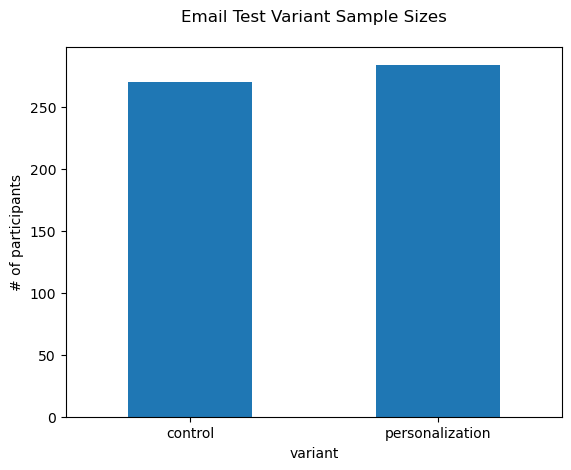

In [84]:
# check we have variant sizes as expected

# count unique users in each variant
allocation = email.groupby(['variant'])['user_id'].nunique()

# plot a bar chart
allocation.plot(kind = 'bar')

plt.title('Email Test Variant Sample Sizes\n')
plt.xlabel('variant')
plt.ylabel('# of participants')
plt.xticks(rotation = 0)

plt.show()


In [89]:
# understand whether each user converted

# group by user and variant and then unstack to give dataframe of all participants in their groups with their conversion status 
subscribers = email.groupby(['user_id','variant'])['converted'].max()

subscribers = pd.DataFrame(subscribers.unstack(level=1))

print(subscribers.head())

variant    control personalization
user_id                           
a100000526     NaN            True
a100000530     NaN            True
a100000534     NaN           False
a100000538     NaN            True
a100000542     NaN            True


In [127]:
# create control and test series
control = subscribers['control'].dropna()
test = subscribers['personalization'].dropna()

# convert series from object to boolean
control = control.astype('bool')
test = test.astype('bool')

# print conversion rates
print("Control conversion rate: ", str(round(np.mean(control)*100,2))+'%')
print("Test conversion rate: ", str(round(np.mean(test)*100,2))+'%')


Control conversion rate:  28.15%
Test conversion rate:  39.08%


In [147]:
# define test lift function

def test_lift(control, test):
    control_mean = np.mean(control)
    test_mean = np.mean(test)

    # calculate test lift vs. control
    lift = (test_mean - control_mean) / control_mean
    return lift

In [149]:
# testing for significance (independent t test)

# calculate test lift vs. control
lift = test_lift(control, test)
print("Test lift: ", str(round(lift*100, 2))+'%')

# run a independent samples t test to asses significance (note: assumes equal variance)
t = ttest_ind(control, test)

print(t)

Test lift:  38.85%
TtestResult(statistic=-2.734329944750507, pvalue=0.0064514878446941815, df=552.0)


In [187]:
# AB testing function with segmentation

def ab_testing_segment(segment):
    
    for subsegment in np.unique(email[segment].values):
        print(subsegment)
    
        # create a df for each language
        subsegment_data = email[(email[segment] == subsegment)]
    
        subscribers = subsegment_data.groupby(['user_id', 'variant'])['converted'].max()
        subscribers = pd.DataFrame(subscribers.unstack(level=1))
        
        control = subscribers['control'].dropna()
        test = subscribers['personalization'].dropna()
    
        control = control.astype('bool')
        test = test.astype('bool')
    
        lift = test_lift(control, test)
        t = ttest_ind(control, test)
        
        print("Test lift: ", str(round(lift*100, 2))+'%')
        print(t, '\n')

In [189]:
ab_testing_segment('age_group')

0-18 years
Test lift:  121.4%
TtestResult(statistic=-2.966044912142212, pvalue=0.003872449439129706, df=89.0) 

19-24 years
Test lift:  106.24%
TtestResult(statistic=-3.0317943847866697, pvalue=0.0030623836114689195, df=105.0) 

24-30 years
Test lift:  161.19%
TtestResult(statistic=-3.861539544326876, pvalue=0.00018743381094867337, df=114.0) 

30-36 years
Test lift:  -100.0%
TtestResult(statistic=3.185906464414798, pvalue=0.0023238487431765337, df=58.0) 

36-45 years
Test lift:  -85.23%
TtestResult(statistic=2.431790127931851, pvalue=0.01797568600978825, df=61.0) 

45-55 years
Test lift:  -72.22%
TtestResult(statistic=2.0654991273179326, pvalue=0.04306233968820123, df=62.0) 

55+ years
Test lift:  -100.0%
TtestResult(statistic=3.326565456420339, pvalue=0.0016358623456360468, df=51.0) 



In [191]:
ab_testing_segment('language_displayed')

Arabic
Test lift:  50.0%
TtestResult(statistic=-0.5773502691896255, pvalue=0.5795840000000001, df=8.0) 

English
Test lift:  39.0%
TtestResult(statistic=-2.2183598646203215, pvalue=0.026991701290720503, df=486.0) 

German
Test lift:  -1.62%
TtestResult(statistic=0.19100834180787182, pvalue=0.8494394170062678, df=42.0) 

Spanish
Test lift:  166.67%
TtestResult(statistic=-2.3570226039551585, pvalue=0.040156718110477524, df=10.0) 



/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
